# Neural Artistic Style Transfer

This interactive notebook shows how to use the python package `style` for performing artistic style transfer between a source and a style image. 

Based on the work of

> Gatys, L. A., Ecker, A. S., & Bethge, M. (2015). 
> A neural algorithm of artistic style. 
> https://arxiv.org/abs/1508.06576

Also incorporating ideas from

> Johnson, J., Alahi, A., & Fei-Fei, L. (2016, October). 
> Perceptual losses for real-time style transfer and super-resolution. 
> In European Conference on Computer Vision (pp. 694-711). Springer, Cham.
> https://arxiv.org/abs/1603.08155


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import torch
import numpy as np
from IPython.display import display, clear_output
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)

Import style

In [2]:
import style
st = style.IteratedStyleTransfer()

### Visualizing Style Transfer

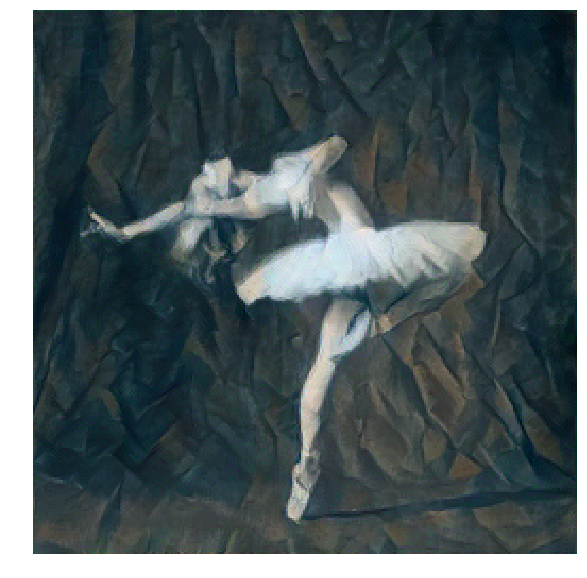

In [126]:
p = style.image.open('etc/dancing.jpg')
a = style.image.open('etc/picasso.jpg')
p = style.image.resize(p, (256,256))
a = style.image.resize(a, (256,256))

# Make sure we all see the same
torch.manual_seed(456)

# choose layers for content and style loss computation
c_id = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[4,8,12]] = 1

# get a generator object
g = st.iterate(p, a, c_id, style_weights, niter=500, lr=1e-2, x=p);

# and iterate (yields every 50 iterations)
fig, ax = plt.subplots()
img = ax.imshow(np.zeros_like(p))
ax.set_axis_off()

for x, l in g:
    clear_output(wait=True)
    img.set_data(x)
    display(fig)
clear_output(wait=True)



## Multiscale

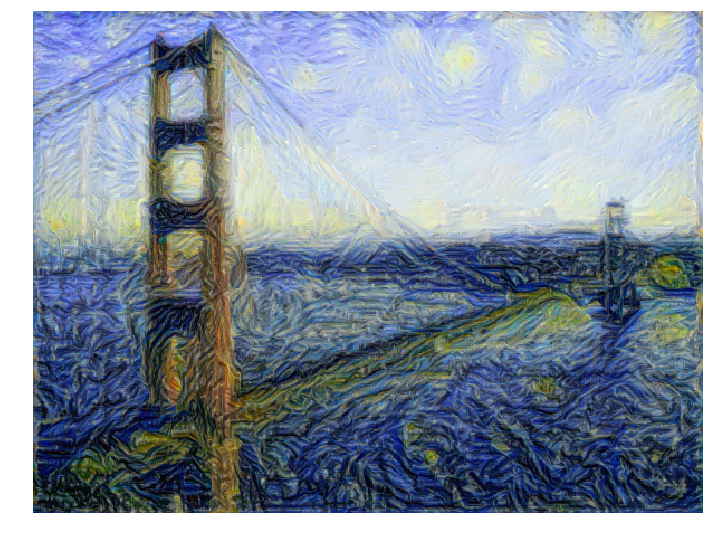

In [127]:
p = style.image.open('etc/bridge.JPG')
a = style.image.open('etc/vangogh.jpg')

sizes = style.image.Pyramid.image_sizes(p.shape, 4)[:-1]
cid = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[2,4,8,12]] = [1, 1, 0.6, 0.2]

imgs = []
for x,_ in st.iterate_multiscale(p, a, cid, style_weights, sizes, x=p, niter=100):
    imgs.append(x)
clear_output(wait=True)

imgs = [style.image.resize(img, sizes[-1]) for img in imgs]
data = np.hstack(imgs)
style.image.save('style.png', data)

plt.imshow(imgs[-1])
plt.axis('off')
plt.show()    

## Seamless

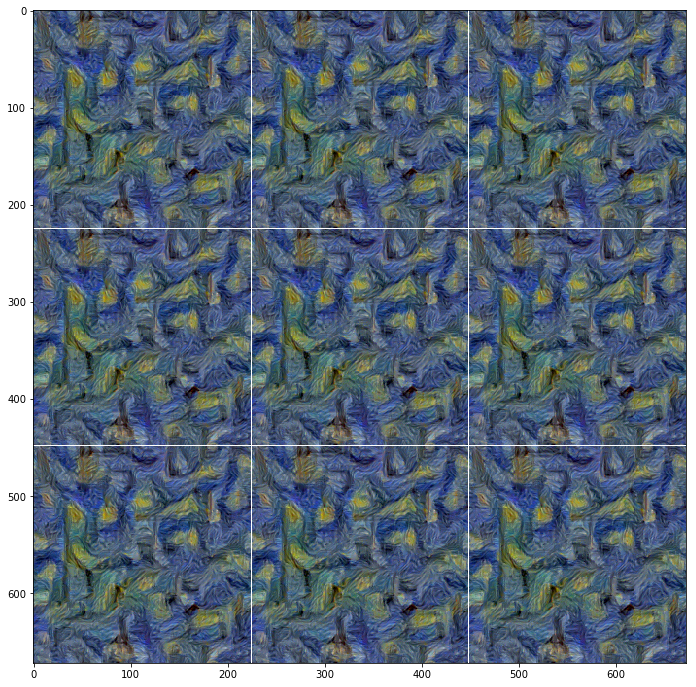

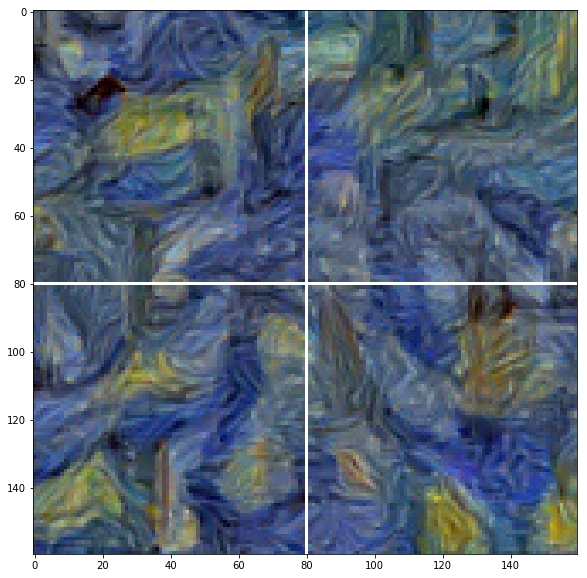

In [128]:
a = style.image.open('etc/vangogh.jpg')
a = style.image.resize(a, (256,256))

np.random.seed(456)
torch.manual_seed(456)

sizes = style.image.Pyramid.image_sizes(a.shape, 3)
cid = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[4,6,8]] = [1]

border = 16
seamless = style.plugins.SeamlessPlugin(a.shape, border)

x,_ = st.run_multiscale(a, a, cid, style_weights, sizes, niter=100, weight_content_loss=0, plugins=[seamless])
x = style.image.borderless_view(x, border)
clear_output(wait=True)

def gen_grid(x, border=True):
    hs = np.hstack((x,x,x))
    vs = np.vstack((hs,hs,hs))

    if border:
        h,w = x.shape[:2]       
        vs[:, [w,2*w]] = 1
        vs[[h,2*h]]=1

    return vs
        
gb = gen_grid(x, border=True)
g = gen_grid(x, border=False)
plt.figure(figsize=(12,12))
plt.imshow(gb)
plt.show()

plt.imshow(gb[144:304,144:304])
plt.show()


In [59]:
style.image.save('seamless_border.png', gb)
style.image.save('seamless.png', g)

## Freezing regions

100%|████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it, loss=[2.741e-03 0.000e+00 2.739e-03 1.752e-06]]


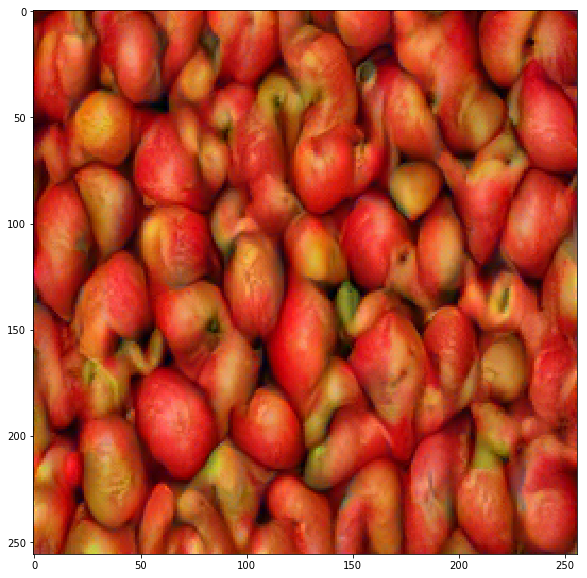

In [328]:
p = style.image.open('etc/dancing.jpg')
a = style.image.open('etc/Apple-links-587431.jpg')
#p = style.image.resize(p, (512,512))
#a = style.image.resize(a, (512,512))

# Make sure we all see the same
#torch.manual_seed(456)

# choose layers for content and style loss computation
c_id = st.conv_ids[12]

style_weights = np.zeros(len(st.conv_ids))
style_weights[[8,10]] = 1

def get_random_init():
    init = a.mean((0,1), keepdims=True)
    init = init + np.random.randn(*a.shape).astype(np.float32)*1e-2
    return init

x,_ = st.run_multiscale(p, a, c_id, style_weights, [(64,64),(128,128),(256,256)], niter=80, lr=1e-2, x=get_random_init(), weight_content_loss=0, scale_style=True);

plt.imshow(x)

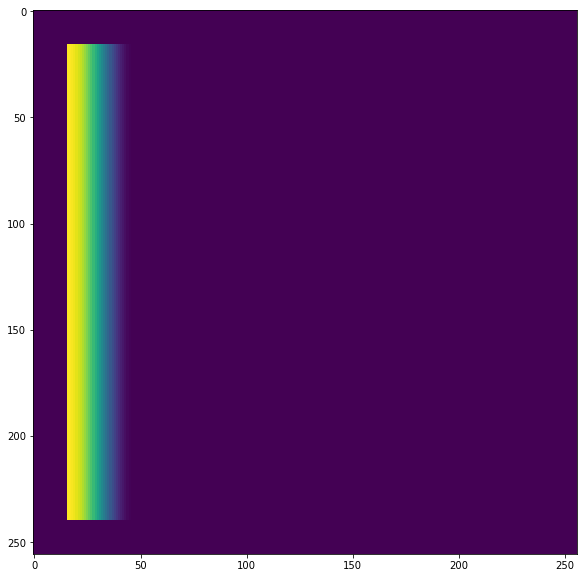

100%|████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it, loss=[2.749e-03 0.000e+00 2.747e-03 1.741e-06]]


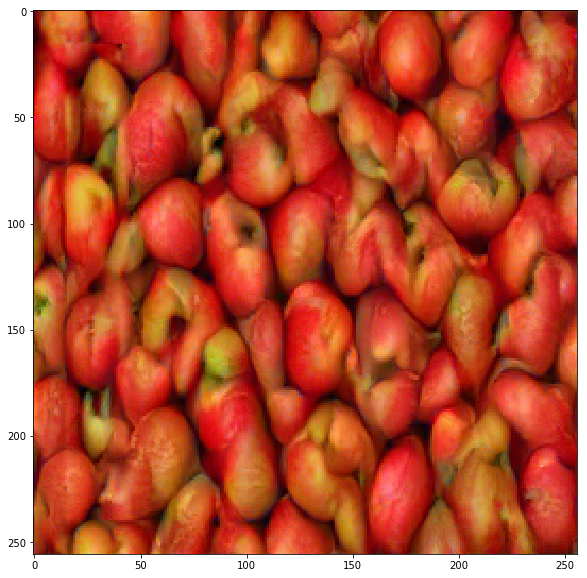

In [388]:

geti = style.image.borderless_view
getb = style.image.border_elements

torch.manual_seed(456)

s = 16
b = 32

mask = np.zeros((x.shape[0],x.shape[1],1))
bmask = getb(geti(mask, s), b)

w = np.linspace(0,np.pi,bmask.fl.shape[1])
w = (1 + np.cos(w)) / 2

bmask.fl[:] = w.reshape(1,-1,1)


plt.imshow(mask[...,0])
plt.show()

seq = [x]
for i in range(5):
    ctx = np.zeros_like(x)    
    getb(geti(ctx, s), b).fl[:] = getb(geti(seq[-1], s), b).fr[:]
    rec = style.plugins.FadeInPlugin(ctx, mask)
    
    newx,_ = st.run_multiscale(x, a, c_id, style_weights, [(64,64),(128,128),(256,256)], niter=80, lr=1e-2, x=get_random_init(), weight_content_loss=0, plugins=[rec], scale_style=True);
    seq.append(newx)
    
plt.imshow(seq[-1])


In [389]:
def gen_final(seq, border=True):
    h = geti(seq[0], s).shape[0]
    w = geti(seq[0], s).shape[1]
    
    final = np.empty((h, w * len(seq) - b * (len(seq) - 1),3))

    o = [0,0]
    for elem in seq:
        final[o[0]:o[0]+h, o[1]:o[1]+w] = geti(elem, s)
        if border:
            final[o[0]:o[0]+h, o[1]] = 0
            final[o[0]:o[0]+h, o[1]+b] = 0
        o[1] += w - b

    return final

style.image.save('final.png', gen_final(seq, border=False))
style.image.save('finalb.png', gen_final(seq, border=True))